<a href="https://colab.research.google.com/github/Polarbeargo/Microsoft-Azure-Machine-Learning-Scholarship-Showcase-Project/blob/master/Cryptocurrency_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Forecasting model of cryptocurrencies prices using machine learning approach with three year data from [Kaggle Bitcoin Price Prediction (LightWeight CSV)
Build Model from Market Data](https://www.kaggle.com/team-ai/bitcoin-price-prediction/version/1).
* This notebook is a enhanced version from the original author [JonathanPhoon](https://www.kaggle.com/jphoon)'s notebook [Bitcoin Time Series Prediction with LSTM](https://www.kaggle.com/jphoon/bitcoin-time-series-prediction-with-lstm) with the following key features improvements:  
  * Applied Bidirectional LSTM instead of LSTM producing much robust outcome in training loss and better result in RMSE.  
  * Applied `shuffle = true` which only shuffle training dataset further optimiz the training result.  
  * Modified `cols, names = list(), list()` to `cols, names = [], []` base on [[] and {} vs list() and dict(), which is better?](https://stackoverflow.com/questions/5790860/and-vs-list-and-dict-which-is-better) improve function efficiency.  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir('/content/drive/My Drive/price_prediction')
!ls

 automl_dependencies.yml
'bitcoin_price_1week_Test - bitcoin_price_Aug2017_1week.csv.gsheet'
'bitcoin_price_Training - bitcoin_price.2013Apr-2017Aug.csv.csv.gsheet'
 BTCUSDKRAKEN
 multi_h5_model.h5
 my_h5_model.h5


In [5]:
import numpy as np
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Bidirectional
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
import seaborn; seaborn.set()
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [80]:
data = pd.read_csv(filepath_or_buffer="BTCUSDKRAKEN", index_col="Date")

* Exploring data

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1380 entries, 2014-01-07 to 2017-10-17
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               1380 non-null   float64
 1   High               1380 non-null   float64
 2   Low                1380 non-null   float64
 3   Close              1380 non-null   float64
 4   Volume (BTC)       1380 non-null   float64
 5   Volume (Currency)  1380 non-null   float64
 6   Weighted Price     1380 non-null   float64
dtypes: float64(7)
memory usage: 86.2+ KB


In [82]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [83]:
data.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-10-13,5429.8,5854.4,5380.1,5640.0,9222.144339,5.178706e+07,5615.511555
2017-10-14,5626.7,5800.0,5556.1,5800.0,3019.946476,1.719205e+07,5692.831135
2017-10-15,5800.0,5840.4,5462.1,5680.0,4536.386215,2.545265e+07,5610.777658
2017-10-16,5673.2,5776.6,5550.0,5738.8,3134.620657,1.778638e+07,5674.172630
2017-10-17,5738.7,5759.9,5535.1,5577.8,3322.439554,1.869327e+07,5626.368279


In [84]:
data.isnull().any()

Open                 False
High                 False
Low                  False
Close                False
Volume (BTC)         False
Volume (Currency)    False
Weighted Price       False
dtype: bool

In [85]:
%matplotlib inline
import plotly
import plotly.graph_objects as go
fig = go.Figure(go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price'))
fig.show()

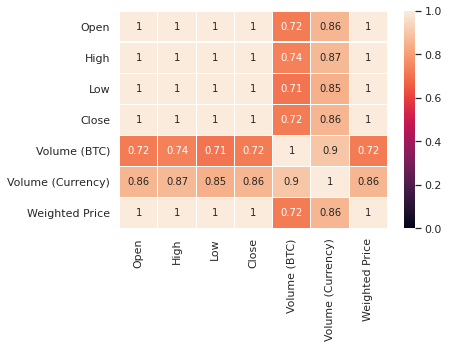

In [86]:
sns.heatmap(data.corr(), annot=True, linewidths=0.1, vmin=0)

* Clean data

In [87]:
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)

In [88]:
fig = go.Figure(go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price'))
fig.show()

* Scaling data using MinMax normalize to fit feature Weighted Price  then transforming it so that the values fit within a range or scale between 0–1.[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [89]:
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1).astype('float32')

In [90]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

* Spilt data

In [91]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

965 415


In [92]:
def to_numpy_array(df, look_back=1):
    X, Y = [], []
    for i in range(len(df) - look_back):
        a = df[i:(i + look_back), 0]
        X.append(a)
        Y.append(df[i + look_back, 0])
    print(len(Y))
    return np.array(X), np.array(Y)

In [93]:
# Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = to_numpy_array(train, look_back)
testX, testY = to_numpy_array(test, look_back)

964
414


In [112]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

* Running Bidirectional LSTM with 300 epoches Modified `shuffle=True` which only shuffle training dataset produce better result in train vs validate loss plot. Detail reference: [For Keras fit method, does “shuffle=True” shuffle BOTH the training and validation samples or just the training dataset?](https://forums.fast.ai/t/for-keras-fit-method-does-shuffle-true-shuffle-both-the-training-and-validation-samples-or-just-the-training-dataset/2992)

In [113]:
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]))))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=True)
model.save("my_h5_model.h5")
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 200)               81600     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 201       
Total params: 81,801
Trainable params: 81,801
Non-trainable params: 0
_________________________________________________________________
None


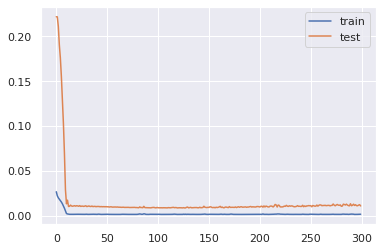

In [114]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

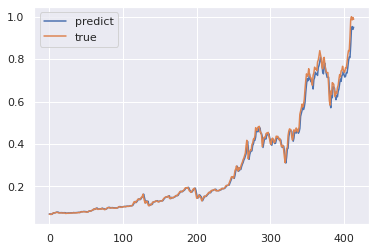

In [115]:
predict = model.predict(testX)
plt.plot(predict, label='predict')
plt.plot(testY, label='true')
plt.legend()
plt.show()

In [116]:
predict_inverse = scaler.inverse_transform(predict.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

* RMSE

In [117]:
rmse = sqrt(mean_squared_error(testY_inverse, predict_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 109.153


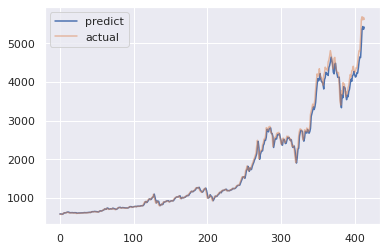

In [118]:
plt.plot(predict_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()
plt.show()

* Convert X to dates

In [119]:
predictDates = data.tail(len(testX)).index

In [120]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
predict_reshape = predict_inverse.reshape(len(predict_inverse))

In [121]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price'))
fig.add_trace(go.Scatter(x=predictDates, y=predict_reshape, name= 'Predict Price'))
fig.show()

* Train with addditional feature

Modified `cols, names = list(), list()` to `cols, names = [], []` base on [[] and {} vs list() and dict(), which is better?](https://stackoverflow.com/questions/5790860/and-vs-list-and-dict-which-is-better)

In [122]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [123]:
values = data[['Weighted Price'] + ['Volume (BTC)'] + ['Volume (Currency)']].values.astype('float32')

In [124]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [125]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.116909,0.000715,0.000177,0.116422,0.000878,0.000216
2,0.116422,0.000878,0.000216,0.115041,0.000373,0.000091
3,0.115041,0.000373,0.000091,0.117474,0.000367,0.000091
4,0.117474,0.000367,0.000091,0.125800,0.000858,0.000225
5,0.125800,0.000858,0.000225,0.120299,0.001164,0.000294


In [126]:
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.116909   0.000715   0.000177  0.116422
2   0.116422   0.000878   0.000216  0.115041
3   0.115041   0.000373   0.000091  0.117474
4   0.117474   0.000367   0.000091  0.125800
5   0.125800   0.000858   0.000225  0.120299


In [127]:
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(965, 1, 3) (965,) (414, 1, 3) (414,)


In [128]:
multi_model = Sequential()
multi_model.add(Bidirectional(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]))))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')

multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=True)
model.save("multi_h5_model.h5")
print(multi_model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_11 (Bidirectio (None, 200)               83200     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 201       
Total params: 83,401
Trainable params: 83,401
Non-trainable params: 0
_________________________________________________________________
None


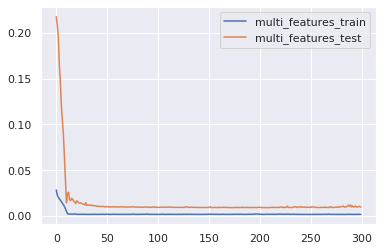

In [129]:
plt.plot(multi_history.history['loss'], label='multi_features_train')
plt.plot(multi_history.history['val_loss'], label='multi_features_test')
plt.legend()
plt.show()

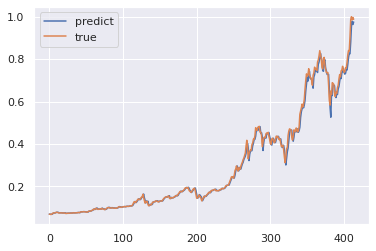

In [130]:
predict = multi_model.predict(test_X)
plt.plot(predict, label='predict')
plt.plot(test_y, label='true')
plt.legend()
plt.show()

In [131]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_predict = concatenate((predict, test_X[:, 1:]), axis=1)
inv_predict = scaler.inverse_transform(inv_predict)
inv_predict = inv_predict[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [132]:
rmse = sqrt(mean_squared_error(inv_y, inv_predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 98.608


In [62]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price'))
fig.add_trace(go.Scatter(x=predictDates, y=inv_predict, name= 'Multi Features Predict Price'))
fig.add_trace(go.Scatter(x=predictDates, y=predict_reshape, name= 'Predict Price'))
fig.show()

- Bidirectional LSTM with single feature of `Weighted Price` have RMSE of 109.153
- Bidirectional LSTM with features of `Volume(BTC)`, `Volume(Currency)` and `Weighted Price` have RMSE of 98.608
- Bidirectional LSTM with multi features shows more accurate results

* Install Azure Machine Learning SDK

In [1]:
pip install --upgrade azureml-sdk

     |████████████████████████████████| 2.0MB 5.4MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 307kB 42.4MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
     |████████████████████████████████| 17.3MB 201kB/s 
     |████████████████████████████████| 28.2MB 186kB/s 
     |████████████████████████████████| 8.6MB 50.2MB/s 
     |████████████████████████████████| 92kB 13.8MB/s 
     |████████████████████████████████| 819kB 57.4MB/s 
     |████████████████████████████████| 40kB 7.5MB/s 
     |████████████████████████████████| 153kB 62.0MB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
     |████████████████████████████████| 972kB 48.8MB/s 
     |████████████████████████████████| 112kB 57.7MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 204kB 57.4MB/s 
     |████████████████████████████████| 2.6MB 52.1MB/s 

In [2]:
import azureml.core
from azureml.core import Workspace
from azureml.core.webservice import Webservice, AksWebservice
from azureml.core.image import Image
from azureml.core.model import Model

print("Azure ML SDK version:", azureml.core.VERSION)

Azure ML SDK version: 1.13.0


In [3]:
from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
import logging

In [ ]:
#Provide the Subscription ID of your existing Azure subscription
subscription_id = "" # <- needs to be the subscription within the Azure resource group for this lesson

#Provide values for the existing Resource Group 
resource_group = "" # <- enter the name of your Azure Resource Group

#Provide the Workspace Name and Azure Region of the Azure Machine Learning Workspace
workspace_name = "" # <- enter the name of the Azure Machine Learning workspace
workspace_region = "eastus" # <- region of your Azure Machine Learning workspace

In [ ]:
ws = Workspace.create(
    name = workspace_name,
    subscription_id = subscription_id,
    resource_group = resource_group, 
    location = workspace_region,
    exist_ok = True)

ws.write_config()

print('Workspace configuration succeeded')

In [ ]:
# Display a summary of the current environment
import pandas as pd
output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

In [ ]:
# register the model for deployment
model = Model.register(model_path = model_path, # this points to a local file
                       model_name = "Cryptocurrency-Price-predictor", # name the model is registered as
                       tags = {'area': "auto", 'type': "regression"}, 
                       description = "Cryptocurrency Price Predictor", 
                       workspace = ws)

print()
print("Model registered: {} \nModel Description: {} \nModel Version: {}".format(model.name, 
                                                                                model.description, model.version))

## Deploy the Model as a Web Service

In [ ]:
%%writefile scoring_service.py

import json
import numpy as np
import pandas as pd
import azureml.core
import azureml.train.automl
from azureml.core.model import Model
import joblib

columns = ['']

def init():
    # One-time initialization of predictive model and scaler
    global model
    
    print("Azure ML SDK version:", azureml.core.VERSION)
    model_name = 'Cryptocurrency-Price-predictor'
    print('Looking for model path for model: ', model_name)
    model_path = Model.get_model_path(model_name=model_name)
    print('Looking for model in: ', model_path)
    model = joblib.load(model_path)
    print('Model loaded...')

def run(input_json):     
    try:
        inputs = json.loads(input_json)
        data_df = pd.DataFrame(np.array(inputs).reshape(-1, len(columns)), columns = columns)
        # Get the predictions...
        prediction = model.predict(data_df)
        prediction = json.dumps(prediction.tolist())
    except Exception as e:
        prediction = str(e)
    return prediction

In [ ]:
from azureml.core import Environment
myEnv = Environment.from_conda_specification('myenv', './automl_dependencies.yml')
myEnv.register(workspace=ws)

In [ ]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice

inference_config = InferenceConfig(entry_script='scoring_service.py', environment=myEnv)
aci_config = AciWebservice.deploy_configuration(
    cpu_cores = 1, 
    memory_gb = 1, 
    tags = {'name': 'aci-cluster'}, 
    description = 'Cryptocurrency Price Prediction Web Service')

Now you are ready to begin your deployment to the Azure Container Instance.

Run the following cell:  you may be waiting **20-25 minutes** for completion, while the _Running_ tag adds progress dots.

You will see output similar to the following when your web service is ready: 

`
Succeeded
ACI service creation operation finished, operation "Succeeded"`

In [ ]:
from azureml.core import Webservice
from azureml.exceptions import WebserviceException

service_name = 'cryptocurrency-price-prediction'

# Remove any existing service under the same name.
try:
    Webservice(ws, service_name).delete()
except WebserviceException:
    pass

webservice = Model.deploy(workspace=ws,
                       name=service_name,
                       models=[model],
                       inference_config=inference_config,
                       deployment_config=aci_config)
webservice.wait_for_deployment(show_output=True)

## Test the deployed web service

### Make direct calls on the service object

In [ ]:
import json

data1 = []

data2 = [[], 
         []]

result = webservice.run(json.dumps(data1))
print('Predictions for data1')
print(result)

result = webservice.run(json.dumps(data2))
print('Predictions for data2')
print(result)

### Consume the Deployed Web Service

Execute the code below to consume the deployed webservice over HTTP.

In [ ]:
import requests

url = webservice.scoring_uri
print('ACI Service: {} scoring URI is: {}'.format(service_name, url))
headers = {'Content-Type':'application/json'}

response = requests.post(url, json.dumps(data1), headers=headers)
print('Predictions for data1')
print(response.text)
response = requests.post(url, json.dumps(data2), headers=headers)
print('Predictions for data2')
print(response.text)